## 04.Full spectral fitting of a passively evolving galaxy;

This notebook will demosntrate how we can get redshift of a passively evoluving (i.e. no emission lines) galaxy with NIRISS spectra plus direct image. Currently, specutils does not provide a full-spectral fitting functionality, but is one of good use cases of NIRISS spectra.

Here we use a third party package, [gsf v1.2](https://github.com/mtakahiro/gsf/tree/version1.2), developed for HST's grism (+broadband photomety) data sets.


In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import urllib.request

from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u

from astropy import __version__ as astropy_version
print('astropy', astropy_version)

astropy 4.0.1.post1


In [3]:
# We here use a third-party package, gsf, which is a redshift/SED fitting software optimized for grism data sets.
# User may need to install a few packages other than gsf itself. Please take a look at the page;
# https://github.com/mtakahiro/gsf/tree/version1.2
import gsf
print(gsf.__version__)

from gsf.function import get_input
from gsf.gsf import run_gsf_template
from gsf.plot_sed import plot_sed
from gsf.plot_sfh import plot_sfh
from gsf.plot_sed import plot_corner_physparam_frame,plot_corner_physparam_summary

1.1.1


### 0. Download notebook 01 products
These can be also obtained by running the notebooks.

In [ ]:
if not os.path.exists('./output'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/output.zip'
    boxfile = './output.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()
else:
    print('Already exists')

### Open 1D spectrum:

Text(0, 0.5, 'Flux nu')

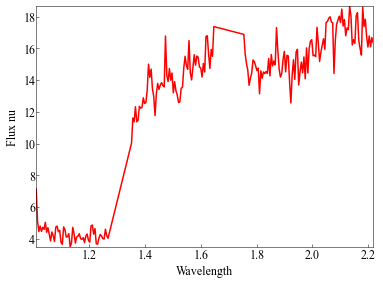

In [6]:
DIR_OUT = './output/'
filt  = 'f200w'
grism = 'G150C'
id    = '00003'

# Load observed spectrum;
fdfile_1d = '%sl3_nis_%s_s%s_1d.fits'%(DIR_OUT, grism, id)
fd = fits.open(fdfile_1d)[1].data

wave = fd['wavelength'] # in um
flux_cont = fd['flux'] # in Mjy/sr
flux_err = fd['uncertainty'] # in Mjy/sr
plt.errorbar(wave, flux_cont, ls='-')

plt.xlabel('Wavelength')
plt.ylabel('Flux nu')

In [7]:
f_noise = 1
f_scale = 1.0

# Create an input file for gsf;
file = '%sl3_nis_%s_s%s_1d_cont_fnu.txt'%(DIR_OUT, grism, id)
fw = open(file,'w')
fw.write('# wavelength flux fluxerr\n')
for ii in range(len(wave)):
    fw.write('%.5e %.5e %.5e\n'%(wave[ii]*1e4, flux_cont[ii]*f_scale, flux_err[ii]*f_noise*f_scale))
fw.close()

### Use gsf

In [8]:
####################
# GSF;
#
# Template using gsf
#
fplt = 0

# Download template;
# You could also generate with gsf, but would take extra time.
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/templates.zip'
boxfile = './templates.zip'
urllib.request.urlretrieve(boxlink, boxfile)
zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

# Auto load input dictionary;
inputs = get_input()

# change Z;
if os.path.exists('./templates/ms.fits'):
    fplt = 1

inputs['ID'] = id

# Initial guess of redshift, or redshift if known. 
# This does not matter much, as we will also do redshift fit later.
inputs['ZGAL'] = 2.0

# Metallicity range, in logZsun, if you like to vary Z;
'''
inputs['ZMIN'] = -0.8
inputs['ZMAX'] = 0.4
inputs['DELZ'] = 0.2
'''
# Or fixed;
inputs['ZFIX'] = 0.0

# MISC;
DIR_EXTR = './'
spec_file = file

inputs['DIR_EXTR'] = DIR_EXTR
inputs['SPEC_FILE'] = spec_file
inputs['DIR_FILT'] = '/Users/tmorishita/GitHub/gsf/gsf/example/filter/'
inputs['CAT_BB'] = 'l3_nis_flux.cat'
inputs['FILTER'] = '309,310,311' # Each number corresponds to EAZY's filter ids.

# Visual inspection;
# Set to 0 (False), as Notebook cannot show actively iterating plot;
inputs['ZVIS'] = 0

# Template used;
inputs['BPASS'] = 1
inputs['AGE'] = '0.01,0.03,0.1,0.3,1.0'

# Emission line masking, if you want?
#LW = [3727, 4341, 4861, 4960, 5008, 6563, 6717, 6731]
#inputs['LINE'] = LW

# Morphology convolution; Necessary for NIRISS spectra;
filt = 'f200w'
inputs['MORP'] = 'moffat'
inputs['MORP_FILE'] = '%s/l3_nis_%s_%s_s%s_moffat.txt'%(DIR_OUT, filt, grism, id)

# Then, run template generate function;
mb = run_gsf_template(inputs, fplt=fplt)

No entry: TAU_COMP
set to 0
Metallicity evolution is off.
No FIR is implemented.
############################
Making templates at 2.0000
############################
Template resolution is unknown.
Set to 50.0 km/s.
Templates convolution (intrinsic morphology).
Template convolution with Moffat.


In [9]:
# Do a quick fit at z=z_guess;
mb.zprev = mb.zgal
out, fm_tmp, xm_tmp = mb.quick_fit(mb.zgal, 1, mb.Cz0, mb.Cz1)

########################
### Fitting Function ###
########################
READ data with 1.0 1.0 2.0
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5
Start quick fit;



#####################################
Zbest, chi are; 0 24.2954327
Params are; [[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 2799
    # data points      = 223
    # variables        = 7
    chi-square         = 5247.81346
    reduced chi-square = 24.2954327
    Akaike info crit   = 718.322088
    Bayesian info crit = 742.172291
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0:  0.78826670 (init = 1)
    A1:  2.9145e-04 (init = 1)
    A2:  1.5863e-05 (init = 1)
    A3:  1.0301e-06 (init = 1)
    A4:  16.3758200 (init = 1)
    Av:  0.44

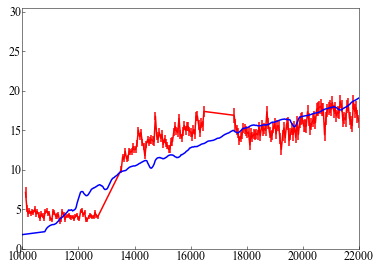

In [10]:
# Open Fitted spectrum;
flux_all, wave_all = mb.fnc.tmp04_val(out, mb.zgal, mb.lib_all)

# Re-retrieved Observed spectrum;
fd_obs = ascii.read(file)
wave_obs = fd_obs['wavelength'] # in um
flux_obs = fd_obs['flux'] # in Mjy/sr
flux_err_obs = fd_obs['fluxerr'] # in Mjy/sr

# plot;
plt.errorbar(wave_obs, flux_obs, yerr=flux_err_obs, ls='-', color='r', label='data')
plt.errorbar(wave_all, flux_all, ls='-', color='b', label='template')
plt.xlim(10000, 22000)
plt.legend(loc=2)
plt.show()

### Now, we improve fit by finding the true redshift;

In [11]:
# Preparing Fitting Spectral Template;
# Here, we use 5 templates for find redshift;
dict_gsf = mb.read_data(mb.Cz0, mb.Cz1, mb.zgal)
ages = [0.01, 0.03, 0.1, 0.3, 1.0]
ntmp = len(ages)

for nn in range(ntmp):
    # For simplicity, no dust attenuation (Av=0), Z fixed to solar (Z=0).
    flux_all, wave_all = mb.fnc.get_template(mb.lib_all, Amp=1.0, T=ages[nn], Av=0.0, Z=0.0, zgal=mb.zgal)
    
    con_tmp = (1000 < wave_all / (1. + mb.zgal)) & (wave_all / (1. + mb.zgal) < 25000)

    # Don't forget to blueshift.
    xm_tmp = wave_all[con_tmp] / (1. + mb.zgal)
    fm_tmp = flux_all[con_tmp]

    if nn == 0:
        fm_tmps = np.zeros((ntmp, len(xm_tmp)), 'float32')

    fm_tmps[nn,:] = fm_tmp[:]

READ data with 1.0 1.0 2.0


In [12]:
# Then, run redshift fitting; 
# dict_gsf : dictionary that includes a lot of things, including data.
# zliml, zlimu : Redshift search range, lower and upper limits.

zspace, chi2s = mb.search_redshift(dict_gsf, xm_tmp, fm_tmps, zliml=1, zlimu=4.0, delzz=0.1)

(0.0, 120.0)

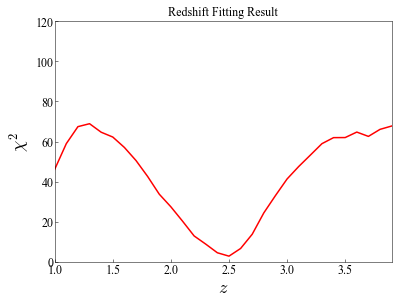

In [13]:
plt.plot(zspace, chi2s[:,1])
plt.ylabel('$\chi^2$', fontsize=18)
plt.xlabel('$z$', fontsize=18)
plt.title('Redshift Fitting Result')
plt.ylim(0, 120)

In [14]:
izfit = np.argmin(chi2s[:,1])
zfit = zspace[izfit]
print('zfit is %.2f'%(zfit))

zfit is 2.50


In [15]:
# Repeat the quick fit at the proposed redshift;
inputs['ZGAL'] = zfit
inputs['NMCZ'] = 30

# Update with a new z input
mb = run_gsf_template(inputs, fplt=fplt)

mb.zprev = mb.zgal
out, fm_tmp, xm_tmp = mb.quick_fit(mb.zgal, 1, mb.Cz0, mb.Cz1)

No entry: TAU_COMP
set to 0
Metallicity evolution is off.
No FIR is implemented.
############################
Making templates at 2.5000
############################
Template resolution is unknown.
Set to 50.0 km/s.
Templates convolution (intrinsic morphology).
Template convolution with Moffat.
########################
### Fitting Function ###
########################
READ data with 1.0 1.0 2.5000000000000013
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5
Start quick fit;



#####################################
Zbest, chi are; 0 2.83387623
Params are; [[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 3229
    # data points      = 223
    # variables        = 7
    chi-square         = 612.117265
    reduced chi-square = 2.83387623
    Akaike info crit   = 239.174719
    Bayesian info crit = 263.024921
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not inst

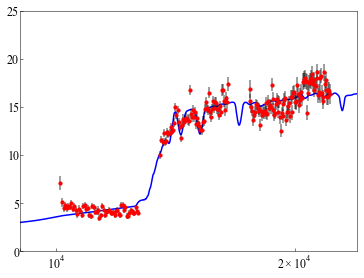

In [16]:
# Plot the result;
flux_all, wave_all = mb.fnc.tmp04_val(out, mb.zgal, mb.lib_all)

# plot;
plt.errorbar(wave_obs, flux_obs, yerr=flux_err_obs, ls='', color='k', zorder=1, alpha=0.5)
plt.scatter(wave_obs, flux_obs, marker='o', color='r',edgecolor='r', s=10, zorder=2, alpha=1)
plt.errorbar(wave_all, flux_all, ls='-', color='b', zorder=0)

plt.xlim(9000, 24000)
plt.ylim(0, 25)
plt.xscale('log')

### Fit looks good --- it captures absorption lines, and balmer break too.

### Now fit redshift in more details;

In [17]:
dict_gsf = mb.read_data(mb.Cz0, mb.Cz1, mb.zgal)

# By usinng the bbest fit template above;
con_tmp = (7000 < wave_all) & (wave_all < 25000)
xm_tmp = wave_all[con_tmp]
fm_tmp = flux_all[con_tmp]

# This works only when spectrum is provided.
mb.fit_redshift(dict_gsf, xm_tmp, fm_tmp, delzz=0.01, zliml=2.4, zlimu=2.6, ezmin=0.01, snlim=0)

READ data with 1.0 1.0 2.5000000000000013
############################
Start MCMC for redshift fit
############################


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [2.96436975 3.33106804 3.39649592]



Recommended redshift, Cz0 and Cz1, 2.50905 0.99618 1.00971, with chi2/nu=2.223





'y'

In [18]:
# This is normalization;
# Should be ~1, as we have already normalized the spectra to BB fluxes.
print('Redshift 16/50/84th percentile range :', mb.z_cz)
print(mb.Czrec0)
print(mb.Czrec1)

Redshift 16/50/84th percentile range : [2.50834338 2.5090468  2.51261506]
0.9961779235057667
1.0097066314392373


In [19]:
mb.zgal = mb.z_cz[1]
mb.zgal

2.509046800931951

### Now, run the whole SED fitting;

No entry: TAU_COMP
set to 0
Metallicity evolution is off.
########################
### Fitting Function ###
########################
READ data with 1.0 1.0 2.5000000000000013
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5



#####################################
Zbest, chi are; 0 2.83387623
Params are; [[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 3229
    # data points      = 223
    # variables        = 7
    chi-square         = 612.117265
    reduced chi-square = 2.83387623
    Akaike info crit   = 239.174719
    Bayesian info crit = 263.024921
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0:  7.56275277 (init = 1)
    A1:  0.00850298 (init = 1)
    A2:  1.57806765 (init = 1)
    A3:  22.1229000

100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [2.70159576 3.17270166 3.15697081]



Recommended redshift, Cz0 and Cz1, 2.51511 0.99448 1.00433, with chi2/nu=2.218



z-distribution figure is not generated.



###############################
Input redshift is adopted.
Starting long journey in MCMC.
###############################




Minimizer Defined

######################
### Starting emcee ###
######################


  5%|▌         | 5/100 [00:00<00:02, 44.26it/s]

No. of CPU is set to 4


100%|██████████| 100/100 [00:01<00:00, 63.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [ 9.6977673  11.14769151 11.22361465 10.77930497 11.55271169 10.23513927
 10.71562227]
###############################
### MCMC part took 1.6 sec ###
###############################
 => Saving data to cpklfile ./chain_00003_PA00_corner.cpkl


##########################
### Writing parameters ###
##########################


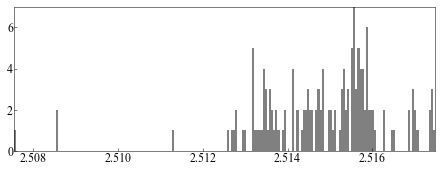

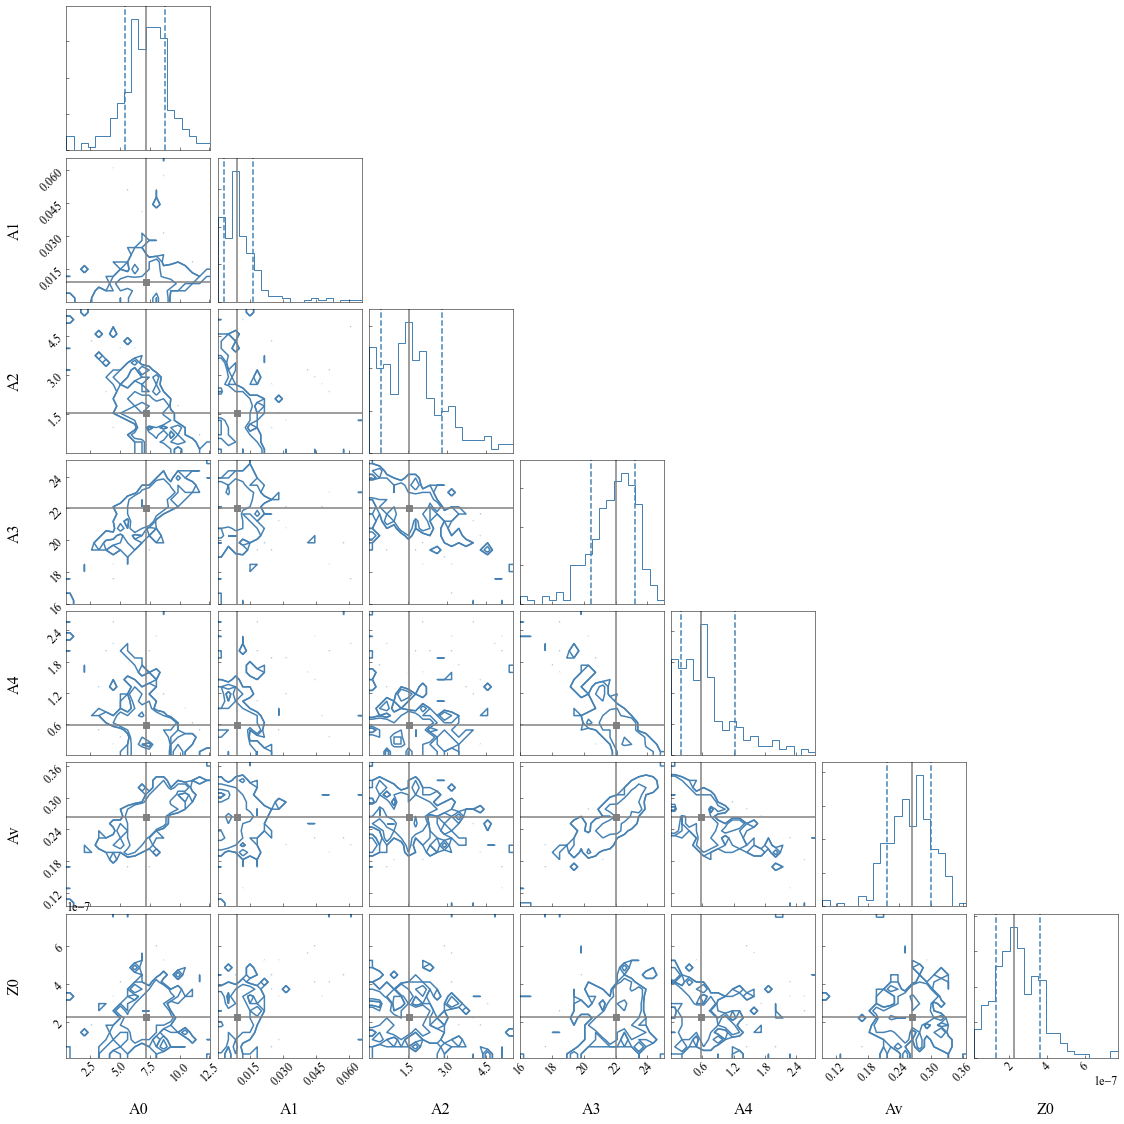

In [20]:
# No interactive fit;
inputs['ZVIS'] = 0
mb.update_input(inputs)
flag_m = 0
flag_suc = mb.main(flag_m, cornerplot=True, specplot=1, sigz=1.0, ezmin=0.01, ferr=0, f_move=False)

READ data with 1.0 1.0 2.5000000000000013
This function (write_lines) needs to be revised.


/Users/tmorishita/anaconda3/envs/jwst_env_016/lib/python3.7/site-packages/gsf-1.2-py3.7.egg/gsf/plot_sed.py:1442: UserWarning: loadtxt: Empty input file: "table_00003_PA00_lines.txt"
  fl = np.loadtxt('table_' + ID + '_PA' + PA + '_lines.txt', comments='#')


Median SN at 3400-3800 is; 15.069805140381943
Median SN at 4200-5000 is; 26.102834148579028
No-of-detection    : 223
chi2               : 619.02
No-of-non-detection: 0
chi2 for non-det   : 0.00
No-of-params       : 6
Degrees-of-freedom : 217
Final chi2/nu      : 2.85



File is missing : _param.fits



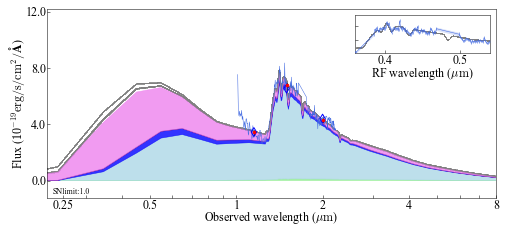

In [21]:
# Plot SED;
plot_sed(mb, fil_path=mb.DIR_FILT,
         SNlim=1.0, figpdf=False, save_sed=True, inputs=mb.inputs, nmc_rand=300,
         dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_label=True, f_fill=True)

SFMS is shifted to Salpeter IMF.
SFMS is shifted to Salpeter IMF.
SFMS is shifted to Salpeter IMF.


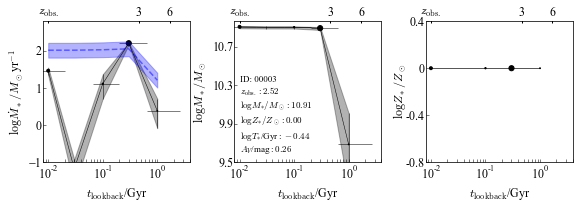

In [22]:
# Plot Star Formation History;
plot_sfh(mb, f_comp=mb.ftaucomp, fil_path=mb.DIR_FILT,
         inputs=mb.inputs, dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_SFMS=True)

### How about adding HST photometry?

In [23]:
inputs['FILTER'] = '309,310,311,308,1,4,6,202,203,204,205'

# Update with filters
mb = run_gsf_template(inputs, fplt=fplt)

No entry: TAU_COMP
set to 0
Metallicity evolution is off.
No FIR is implemented.
############################
Making templates at 2.5000
############################
Template resolution is unknown.
Set to 50.0 km/s.
Templates convolution (intrinsic morphology).
Template convolution with Moffat.


########################
### Fitting Function ###
########################
READ data with 1.0 1.0 2.5000000000000013
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5



#####################################
Zbest, chi are; 0 3.85403375
Params are; [[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 3999
    # data points      = 231
    # variables        = 7
    chi-square         = 863.303559
    reduced chi-square = 3.85403375
    Akaike info crit   = 318.538542
    Bayesian info crit = 342.635466
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0:  2.0865e-04 (init = 1)
    A1:  9.6477e-04 (init = 1)
    A2:  3.15552114 (init = 1)
    A3:  23.8674559 (init = 1)
    A4:  0.04303338 (init = 1)
    Av:  0.2863

100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [2.9166341  2.98668812 2.90314217]



Recommended redshift, Cz0 and Cz1, 2.49937 0.99794 1.00109, with chi2/nu=2.902





  0%|          | 0/100 [00:00<?, ?it/s]

z-distribution figure is not generated.



###############################
Input redshift is adopted.
Starting long journey in MCMC.
###############################




Minimizer Defined

######################
### Starting emcee ###
######################
No. of CPU is set to 4


100%|██████████| 100/100 [00:01<00:00, 71.33it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [10.87486081 11.06851935 11.91710628  8.12943238 10.30913235 11.59661358
 11.56936091]
###############################
### MCMC part took 1.4 sec ###
###############################
 => Saving data to cpklfile ./chain_00003_PA00_corner.cpkl


##########################
### Writing parameters ###
##########################


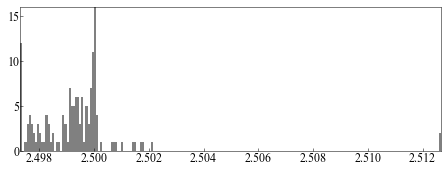

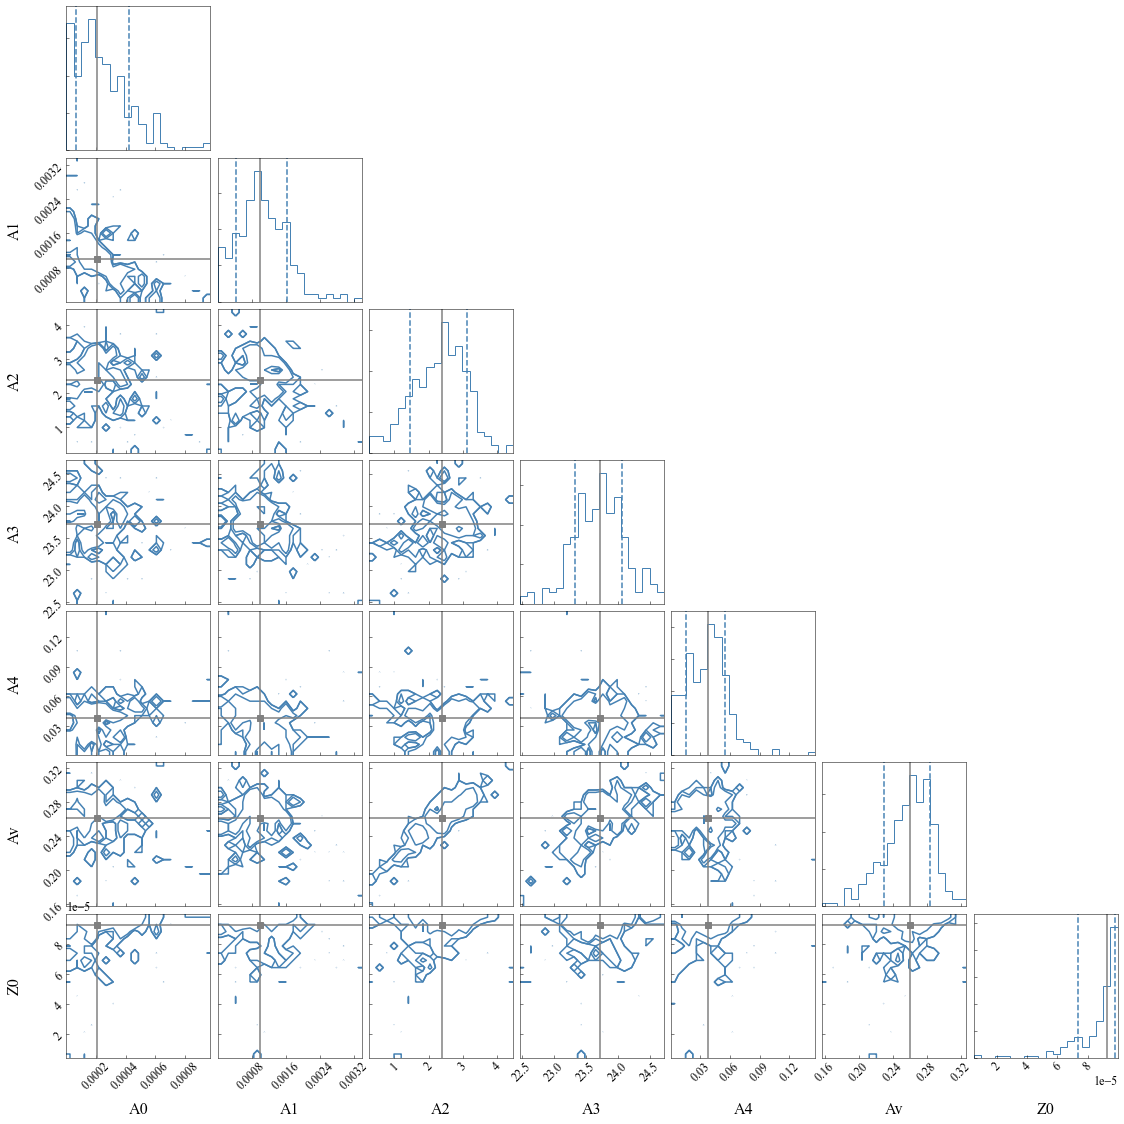

In [24]:
# No interactive fit;
mb.zprev = zfit
flag_suc = mb.main(flag_m, cornerplot=True, specplot=1, sigz=1.0, ezmin=0.01, ferr=0, f_move=False)

READ data with 1.0 1.0 2.5000000000000013
This function (write_lines) needs to be revised.


/Users/tmorishita/anaconda3/envs/jwst_env_016/lib/python3.7/site-packages/gsf-1.2-py3.7.egg/gsf/plot_sed.py:1442: UserWarning: loadtxt: Empty input file: "table_00003_PA00_lines.txt"
  fl = np.loadtxt('table_' + ID + '_PA' + PA + '_lines.txt', comments='#')


Median SN at 3400-3800 is; 15.223530657469805
Median SN at 4200-5000 is; 26.229032477636608
No-of-detection    : 231
chi2               : 857.27
No-of-non-detection: 0
chi2 for non-det   : 0.00
No-of-params       : 6
Degrees-of-freedom : 225
Final chi2/nu      : 3.81


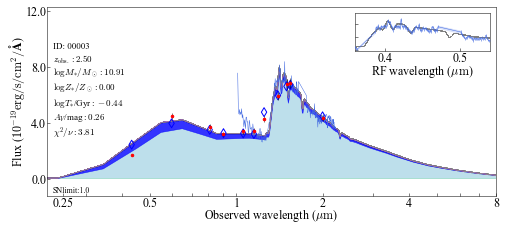

In [27]:
# Plot SED;
plot_sed(mb, fil_path=mb.DIR_FILT,
         SNlim=1.0, figpdf=False, save_sed=True, inputs=mb.inputs, nmc_rand=300,
         dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_label=True, f_fill=True)

Total stellar mass is 8.11e+10


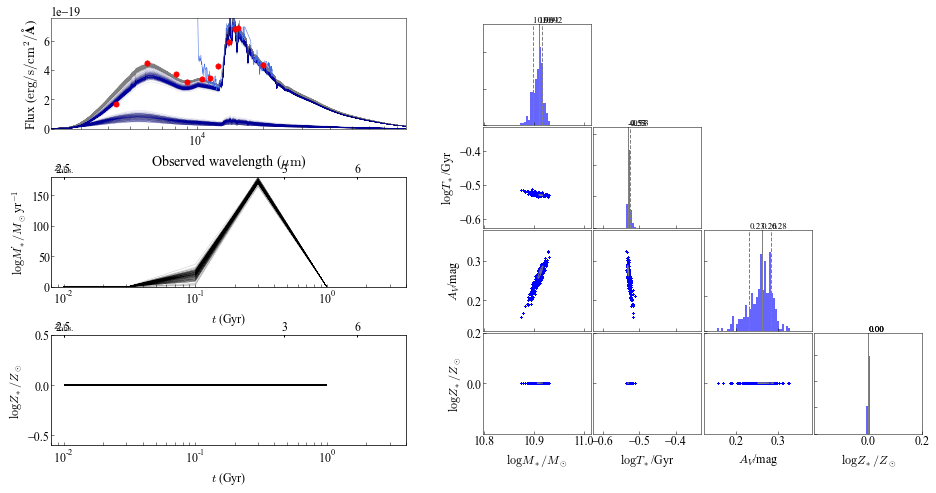

In [26]:
# Physical parameters;
plot_corner_physparam_summary(mb)